In [3]:
import h5py
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import emcee
import corner
import numpy.ma as ma
from scipy.interpolate import interp1d
import pickle
from scipy import interpolate

[-2.46385387e-48  9.01751563e-40 -1.35548132e-31  1.21841049e-23
 -6.93709065e-16  1.18582459e-08  8.91759378e-01]
101


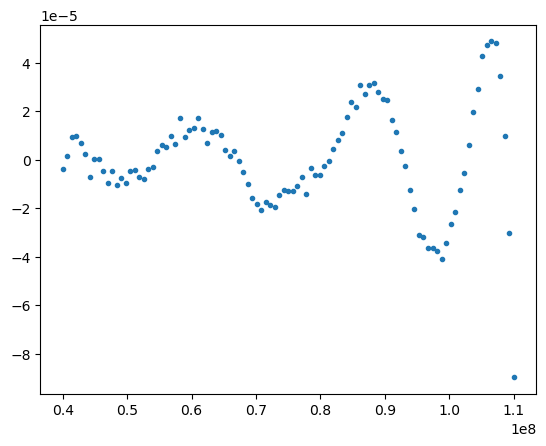

In [4]:
RLC_S11_df = pd.read_csv('/home/saurabhs/Documents/gopi/Saras_New/Calibrated_ADHOC_S11_TEST4_SARAS4.csv')

RLC_S11 = list(RLC_S11_df.columns)
v=RLC_S11_df.iloc[0]
v=v*1e6
RLC_S11 = [float(i) for i in RLC_S11]

fit=np.polyfit(v,RLC_S11,6)
print(fit)
p0,p1,p2,p3,p4,p5,p6=fit
model= np.polyval(fit,v)
res=model-RLC_S11
plt.plot(v,res,'.')
print(len(v))


In [5]:
avg = h5py.File('/home/saurabhs/Documents/amarnath/hdatasets/2025-04-13_053004.pyavg','r')
med = h5py.File('/home/saurabhs/Documents/amarnath/hdatasets/2025-04-13_053004.pymed','r')

In [6]:
print(list(avg.keys()))
print(list(med.keys()))

['SPCD', 'SPCF', 'mask', 'params', 'pyavg']
['11', '12', '22', 'lst', 'mask', 'params', 'pymedian', 'pytag', 'time']


In [7]:
#Frequencies
avg['pyavg'].keys()
sfreq = avg.attrs['sfreq']
print(avg.attrs.keys())
freq=np.arange(0,8193,1)*sfreq*1e3
ind_freq=np.logical_and((freq>=40),(freq<=110))
req_freq=freq[ind_freq]*1e6
len_freq=len(freq[ind_freq])
print(len(freq[ind_freq]))

<KeysViewHDF5 ['sfreq']>
2294


2294
110000000.0 40000000.0


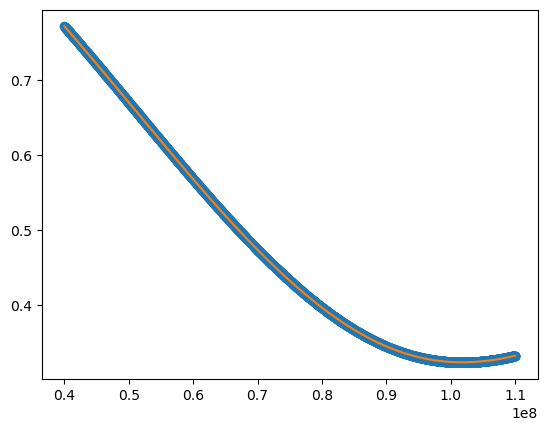

In [8]:
#Interpolating the RLC for the required frequencies
interpolator = interp1d(v, RLC_S11, kind='cubic')
freq_new = np.linspace(v.min(), v.max(), len_freq)
print(len(freq_new))
RLC_new=interpolator(freq_new)
print(freq_new.max(), freq_new.min())
plt.plot(freq_new,RLC_new,'o')
plt.plot(req_freq,RLC_new)
#plt.plot(v,RLC_S11)
plt.show()

[-2.52316013e-48  9.27244989e-40 -1.40037092e-31  1.25994681e-23
 -7.15007581e-16  1.24280736e-08  8.85664268e-01]


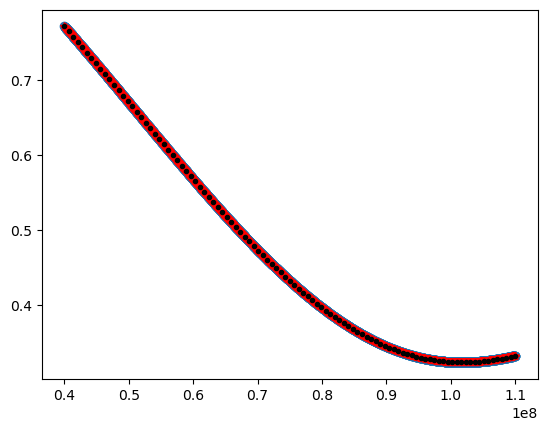

In [9]:
fit=np.polyfit(req_freq,RLC_new,6)
print(fit)
p0,p1,p2,p3,p4,p5,p6=fit
model= np.polyval(fit,req_freq)
res=model-RLC_new
plt.plot(req_freq,model,'o')
plt.plot(req_freq,RLC_new,'r*')
plt.plot(v,RLC_S11,'k.')


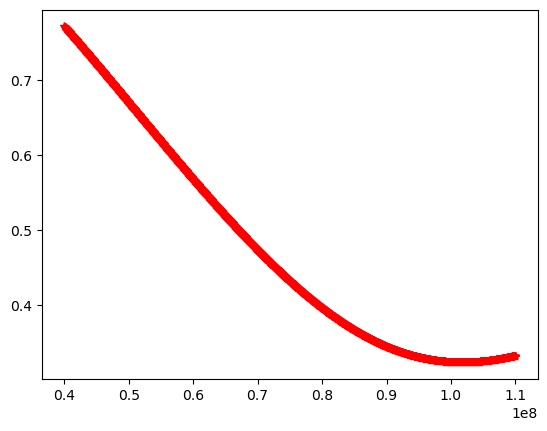

In [10]:
p0, p1, p2, p3, p4, p5, p6=[-2.52316013,  9.27244989, -1.40037092,  1.25994681, -7.15007581,  1.24280736,  8.85664268]
gA_True=np.polyval([p0*1e-48, p1*1e-40, p2*1e-31, p3*1e-23, p4*1e-16, p5*1e-8, p6*1e-1],req_freq)
plt.plot(req_freq,gA_True)
plt.plot(req_freq,RLC_new,'r*')

## 21cm signal

In [11]:
path_to_file = '/home/saurabhs/Documents/gopi/Saras_New/Data_18March_wMFP.mat'
path_to_freq = '/home/saurabhs/Documents/gopi/Saras_New/freq_saras.txt'

data     = scipy.io.loadmat(path_to_file)
data     = data['Data2']/1e3  # Kelvin units

fr       = np.loadtxt(path_to_freq) #Frequency in MHz
signal_function   = interpolate.interp1d(fr, data, fill_value="extrapolate")

In [12]:
F_MIN = 40 # define your own

F_MAX = 110 # define your own

NO_OF_CHANNELS = len_freq # define your own

freq_array = np.linspace(F_MIN, F_MAX, NO_OF_CHANNELS) 

signals = signal_function(freq_array)

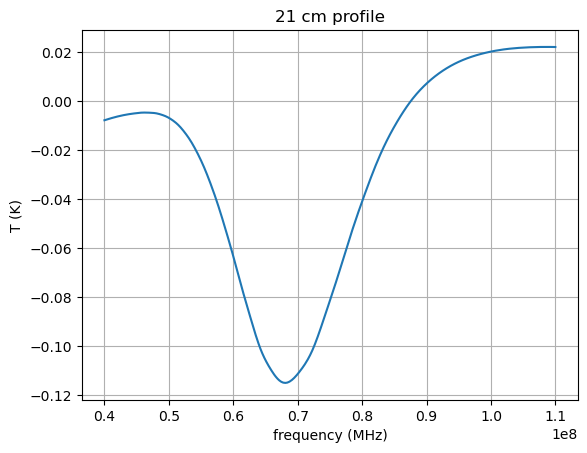

In [13]:
sig_idx = 56
sig21cm=signals[sig_idx]
plt.plot(req_freq, sig21cm)

plt.title('21 cm profile')
plt.xlabel('frequency (MHz)')
plt.ylabel('T (K)')
plt.grid(True)
plt.show()

### Averaged Data

In [14]:
SPCD_avg=avg['SPCD']#[:, 1::2]
SPCF_avg=avg['SPCF']#[:, 1::2]
mask_avg=avg['mask']#[:, 1::2].real
print(SPCF_avg.shape)
SPCD_avg=SPCD_avg[0, ind_freq].real
SPCF_avg=SPCF_avg[0,ind_freq].real
mask_avg=mask_avg[0, ind_freq].real
print(SPCF_avg)

(1, 8193)
[0.02344228 0.         0.02358741 ... 0.         0.02584896 0.        ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2294,)


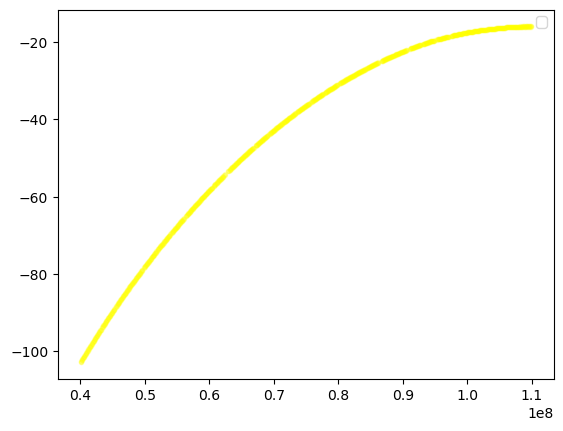

[1. 0. 1. ... 0. 1. 0.]
(1066,)


In [15]:
#plotting the averaged data
print(req_freq.shape)
#plt.scatter(req_freq[mask_avg==0], SPCD_avg.real[mask_avg==0], marker='.', color='red', alpha = 0.7)
plt.scatter(req_freq[mask_avg==1], SPCD_avg[mask_avg==1], marker='.', color='yellow', alpha = 0.2)
plt.legend()
#plt.xlim(0.6e8, 0.7e8)
plt.show()
print(mask_avg.real)
print(SPCD_avg.real[mask_avg==1].shape)

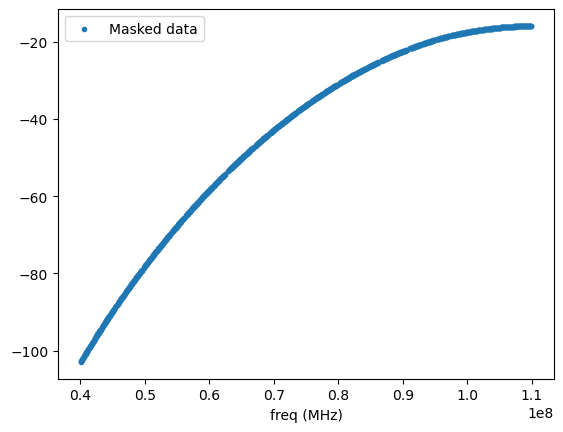

In [16]:
TMeas_exp_avg=ma.masked_array(SPCD_avg,np.logical_not(mask_avg))  ##Masking
plt.scatter(req_freq,TMeas_exp_avg, label='Masked data', marker='.')
#plt.plot(req_freq,SPCD_avg[0][ind_freq].real, alpha=0.8, label=('Data'))
#plt.xlim(0.9e8, 0.91e8)
plt.xlabel('freq (MHz)')
plt.legend()
plt.show()

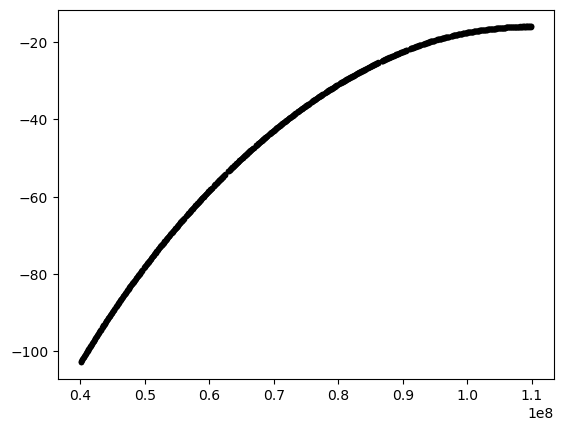

In [17]:
plt.plot(req_freq,TMeas_exp_avg, '.k', label='Masked data')
#plt.scatter(req_freq[mask_avg==1], SPCD_avg[mask_avg==1], marker='o', color='red', alpha = 0.7)
#plt.scatter(req_freq[mask_avg==1], SPCD_avg.real[mask_avg==1], marker='.', color='yellow', alpha = 0.2)

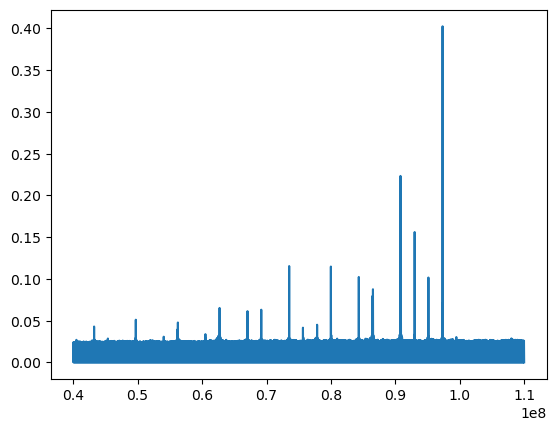

In [18]:
#plotting uncertainities ----> SPCF
plt.plot(req_freq,SPCF_avg)
plt.show()

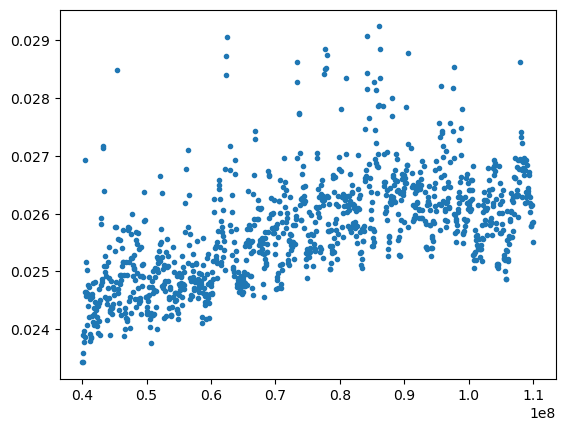

In [19]:
#Masking Uncertainities
uncert=ma.masked_array(SPCF_avg,np.logical_not(mask_avg))  ##Masking
plt.scatter(req_freq,uncert, label='Masked data', marker='.')

## with 21cm signal

<class 'numpy.ma.core.MaskedArray'>
[-0.00774253 -0.00771693 -0.00769132 ...  0.02216145  0.02215934
  0.02215723]
[-102.87815373864673 -- -102.69373556646046 ... -- -16.08636352967983 --]
[-102.88589626653585 -- -102.70142688966732 ... -- -16.064204189953074 --]


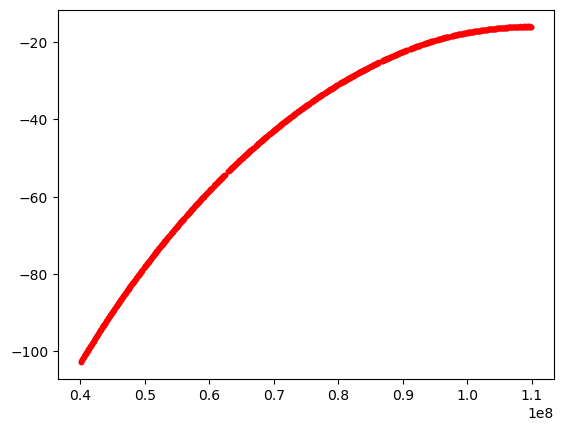

In [20]:
a=1
T21=a*sig21cm+TMeas_exp_avg
print(type(T21))
plt.plot(req_freq,T21, 'k', zorder=1)
plt.plot(req_freq,TMeas_exp_avg, '.r', zorder=2)
print(sig21cm)
print(TMeas_exp_avg)
print(T21)

### Data Median

In [21]:
corr=med['12']
list(corr.keys())

['SPCD', 'SPCF']

In [87]:
SPCD_med=corr['SPCD']#[:, 1::2]
SPCF_med=corr['SPCF']#[:, 1::2]
mask_med=med['mask']#[:, 1::2]
lst_med=med['lst']
time_med=med['time']

In [88]:
print(SPCD_med.shape)
print(SPCF_med.shape)
print(mask_med.shape)


(3471, 8193)
(0, 8193)
(3471, 8193)


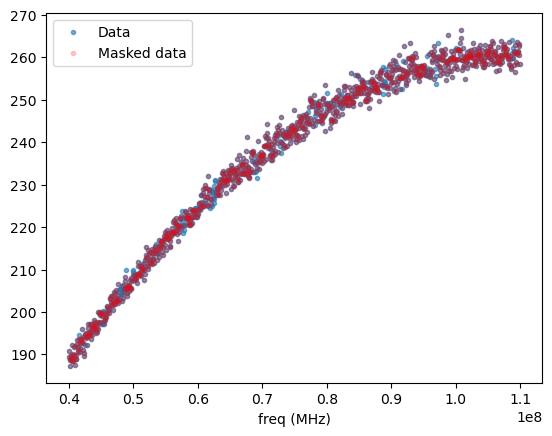

In [57]:
## Plotting masked median data
TMeas_exp=ma.masked_array(SPCD_med[0],np.logical_not(mask_med[0]))  ##Masking
plt.plot(req_freq,SPCD_med[0][ind_freq].real,'.', alpha=0.6, label='Data')
plt.plot(req_freq,TMeas_exp.real[ind_freq],'r.', label='Masked data', alpha=0.2)


plt.xlabel('freq (MHz)')
plt.legend()
plt.show()

In [59]:
df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_New/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_New/saras3_S11_200mm_above_water.s1p", skiprows=5))

d=list(data) #List of the format [Frequency, Magnitude, 
#Phase (in degrees)
c=3*10**8  # speed of light (m/s)
freq_data=[d[i][0] for i in range(len(d)-1)] #frequency

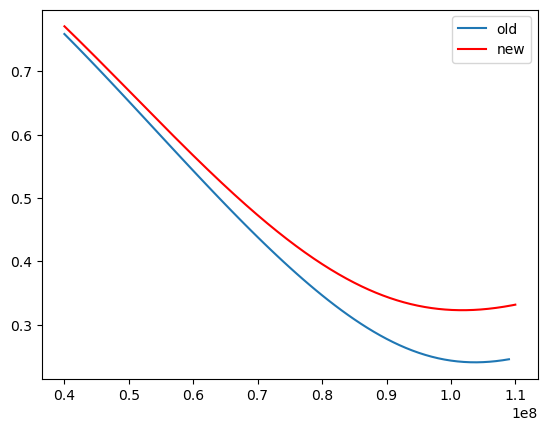

In [166]:
plt.plot(freq_data,rlc, label='old')
plt.plot(req_freq,RLC_new,'r',label='new')
plt.legend()

In [22]:
def Compute_Tmeas_(PA, Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=Pref
    c=3*1e8
    l=l
    N=7
    
    global req_freq #[d[i][0] for i in range(len(d))]
    for i in range(len(req_freq)):
        
        gamma_A=p0*1e-48*req_freq[i]**(N - 1) + p1*1e-40*req_freq[i]**(N - 2) + p2*1e-31*req_freq[i]**(N - 3) + p3*1e-23*req_freq[i]**(N - 4) + p4*1e-16*req_freq[i]**(N - 5) + p5*1e-08*req_freq[i]**(N - 6) + p6*1e-01
        
        phi= (4*math.pi*(req_freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*(1-(gamma_A**2))*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return Tmeas

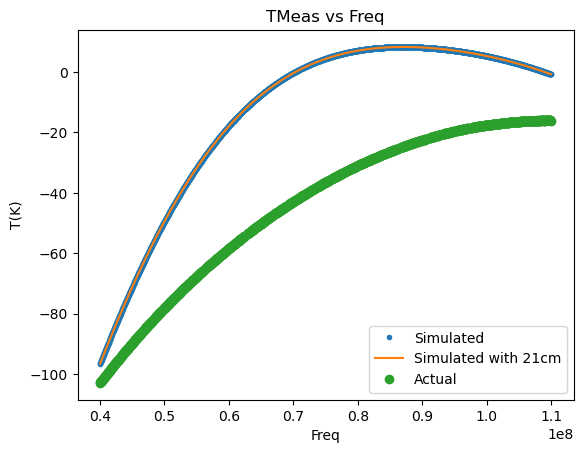

In [23]:
a=1
T=Compute_Tmeas_(300,300, -2.52316013,  9.27244989, -1.40037092,  1.25994681, -7.15007581,  1.24280736,  8.85664268, 70, 0.3, 0.1, 0.15)
T21_sim=T+a*sig21cm
plt.plot(req_freq,T,'.', label="Simulated")
plt.plot(req_freq,T21_sim, label="Simulated with 21cm")
plt.plot(req_freq,TMeas_exp_avg,'o',label="Actual")
plt.legend()
plt.xlabel("Freq")
plt.ylabel("T(K)")
plt.title("TMeas vs Freq")
plt.show()
#print(len(T), len(TMeas_exp.real[ind_freq]), len(req_freq))

In [25]:
########## Define the log-likelihood function
def log_likelihood_full(params,**kwargs):

    # Compute TA expected
    seed=kwargs["seed"]
    #ip_params=kwargs["ip_params"]
    v=kwargs["v"]
    s=kwargs["s"]
    TA_exp=kwargs["TMeas_exp"]
    signal=kwargs["signal"]
    #PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    #TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    #TA_exp=np.array(TA_exp)
    
    # Compute model TA

    a, PA, Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_(PA, Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)+a*signal
    #print(len(TA_model))

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior_full(params, **kwargs):

    
    v=kwargs["v"]
    a, PA, Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    gamma_A=np.polyval([p0*1e-48, p1*1e-40, p2*1e-31, p3*1e-23, p4*1e-16, p5*1e-8, p6*1e-1],v)
    
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and 0<=gamma_N<=1 and PA>0 and Pref>0 and PN>0 and f>0 and (l>0.05 and l<0.23) and a>0):
        return 0.0  # Accept sample
    
    return -np.inf # Reject prior
        
    
######### Define the full log-probability function
    
def log_probability_full(params, **kwargs):
    lp = log_prior_full(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_Full(**kwargs):
    
    # Define parameter names
    parameter_names = ["a", "PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    #args=args
    
    ## Number of walkers and steps
    
    ndim = 14  # Number of parameters
    nwalkers = 150  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=kwargs["initial_value"]

    ## Starting positions for the walkers (making sure that the initial positions satisfy the priors)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior_full(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    
    ## for making sure only positive positional values
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    
    def wrapped_log_prob_full(params):
        return log_probability_full(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrapped_log_prob_full, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood_full(p, **kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [26]:
#evolve MCMC full
#ip_params=[300, -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73, 70, 0.3, 0.1, 0.15]
seed=51
a=0
p0, p1, p2, p3, p4, p5, p6= [-2.52316013,  9.27244989, -1.40037092,  1.25994681, -7.15007581,  1.24280736,  8.85664268]
initials=[a, 300, 300, p0, p1, p2, p3, p4, p5, p6, 70, 0.3, 0.1, 0.15]
nsteps=3000
TMeas_exp=TMeas_exp_avg
v=req_freq
s=uncert#SPCF_avg.real#0.01 #uncertainity
signal=sig21cm
kwargs = {"s":s, "v":v, "seed":seed, "nsteps":nsteps,"initial_value":initials,"TMeas_exp":TMeas_exp, "signal":signal} #"ip_params":ip_params}

full_samples_full, samples_full, best_fit_params_full= evolve_MCMC_Full(**kwargs)

Running MCMC...


100%|█████████████████████████████████████| 3000/3000 [2:55:04<00:00,  3.50s/it]


Text(0.5, 1.0, 'l')

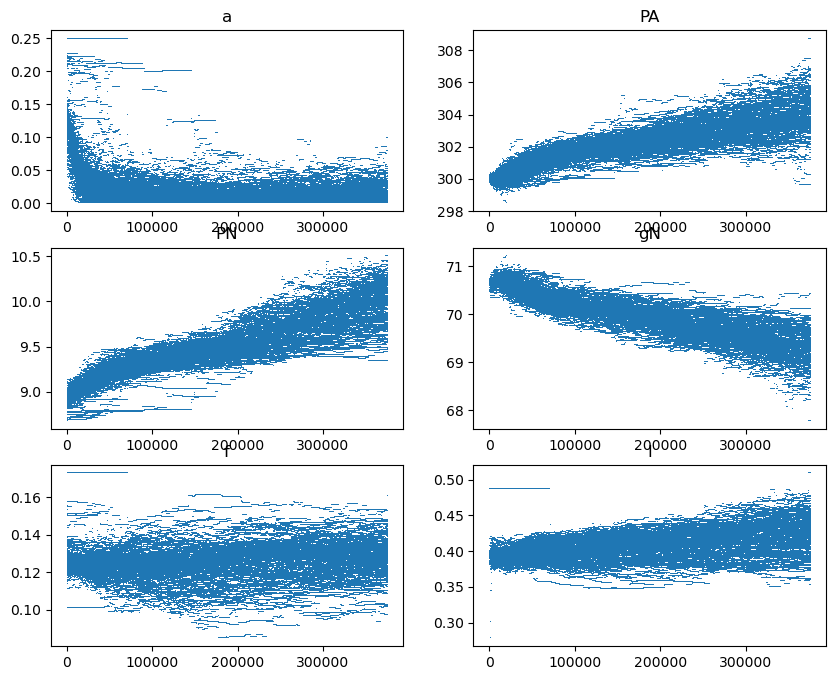

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

axes[0,0].plot(samples_full[:,0],',')
axes[0,0].set_title('a')

axes[0,1].plot(samples_full[:,1],',')
axes[0,1].set_title('PA')

axes[1,0].plot(samples_full[:,9],',')
axes[1,0].set_title('PN')

axes[1,1].plot(samples_full[:,10],',')
axes[1,1].set_title('gN')

axes[2,0].plot(samples_full[:,11],',')
axes[2,0].set_title('f')

axes[2,1].plot(samples_full[:,12],',')
axes[2,1].set_title('l')



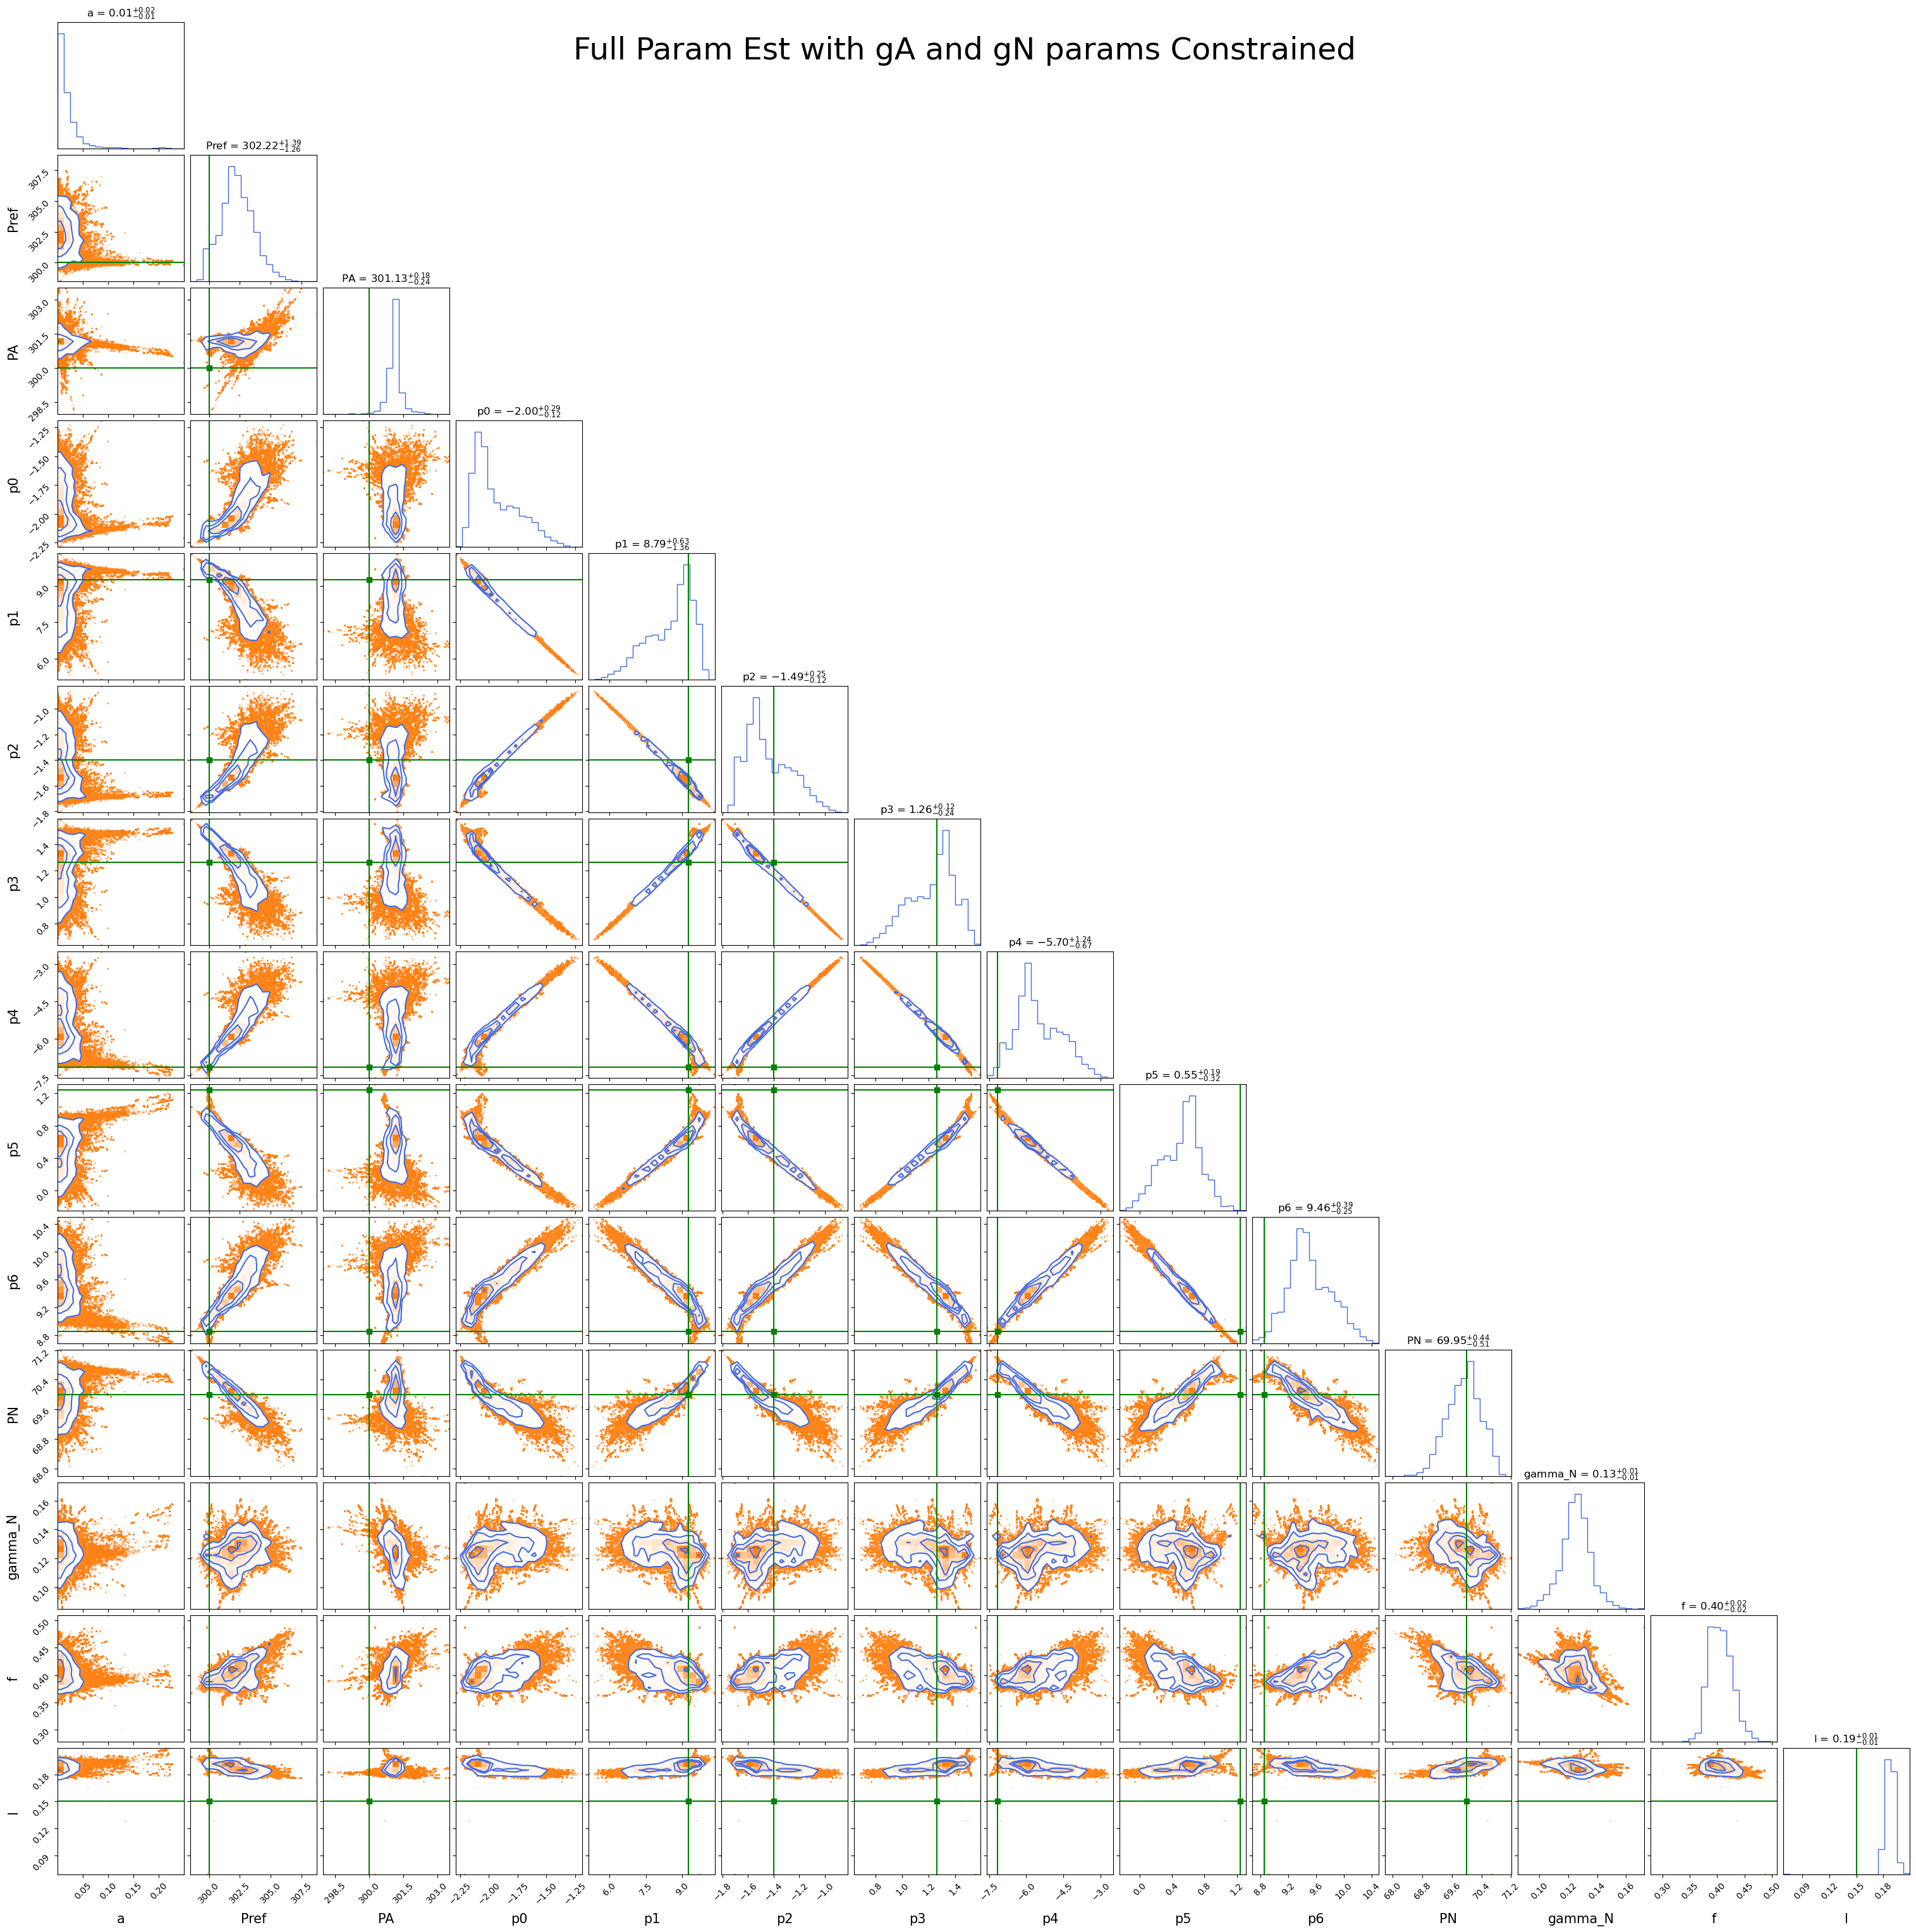

Best-fit parameters (Maximum Likelihood Estimate): [0.0024787739655836773, 306.48746494188026, 302.5502364086845, -1.3697624600893314, 5.858481439253774, -0.942963091854858, 0.7429444235658113, -2.9641296720846197, -0.1728404350017488, 10.396458391846224, 68.76530236250649, 0.12272122879146356, 0.45691949609878635, 0.1786204094228788]


In [29]:
parameter_names = ["a","Pref", "PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]
ip_params=[1, 300, 300,-2.52316013,  9.27244989, -1.40037092,  1.25994681, -7.15007581,  1.24280736,  8.85664268, 70, 0.3, 0.1, 0.15]
#corner plot 
fig = corner.corner(samples_full, labels=parameter_names, show_titles=True, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Full Param Est with gA and gN params Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_Full_gA_1m_.png', dpi=300)
#plt.savefig('Art.png')

plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_full)

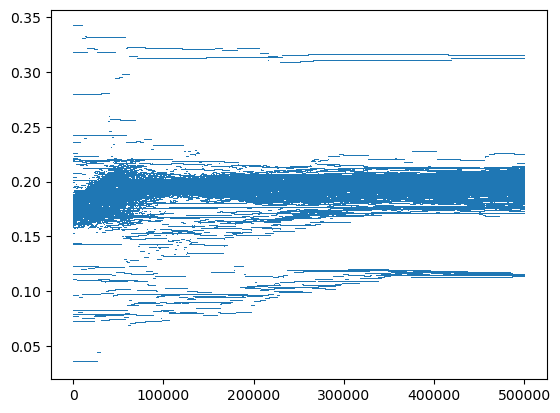

In [311]:
plt.plot(samples_full[:,10],',')

In [30]:
#Saving in a pickel file
result={"seed":seed, "samples":samples_full, "best_fit":best_fit_params_full}

with open(f"results_{seed}.pkl", 'wb') as f:  # open a text file
    pickle.dump(result, f) # serialize the list

f.close()
"""
with open('results.pkl', 'rb') as f:

    result_loaded= pickle.load(f) # deserialize using load()
    print(result_loaded)
"""

"\nwith open('results.pkl', 'rb') as f:\n\n    result_loaded= pickle.load(f) # deserialize using load()\n    print(result_loaded)\n"

Text(0, 0.5, 'S11')

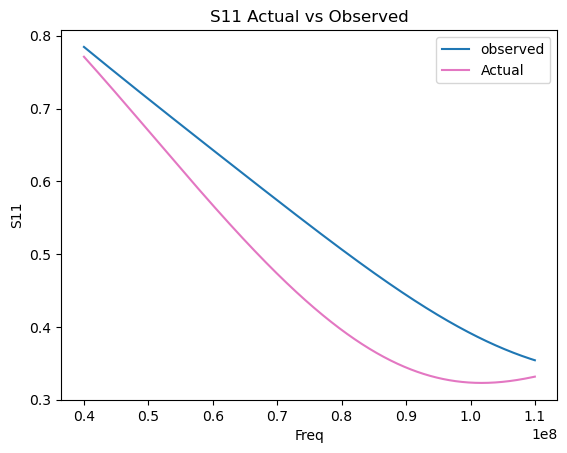

In [31]:
#Reconstructed S11 wrt best fit
v=req_freq
a, PA,Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_full
gamma_A=np.polyval([p0*1e-48, p1*1e-40, p2*1e-31 , p3*1e-23, p4*1e-16, p5*1e-8, p6*1e-1],v)

p0, p1, p2, p3, p4, p5, p6=[-2.52316013,  9.27244989, -1.40037092,  1.25994681, -7.15007581,  1.24280736,  8.85664268]
gA_True=np.polyval([p0*1e-48, p1*1e-40, p2*1e-31, p3*1e-23, p4*1e-16, p5*1e-8, p6*1e-1],v)

yerr=abs(gA_True-gamma_A)
#plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(req_freq,gamma_A,label='observed')
plt.plot(req_freq,gA_True,'tab:pink', label='Actual')
plt.title("S11 Actual vs Observed")
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')

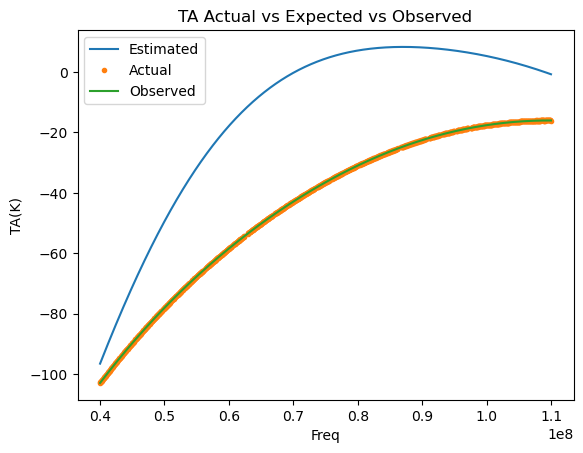

In [33]:
a,PA,Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_full
TObs=Compute_Tmeas_(PA, Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
#print(TMeas_exp.real[ind_freq].shape())
TMeas=TMeas_exp_avg

TEst=Compute_Tmeas_(300,300, -2.52316013,  9.27244989, -1.40037092,  1.25994681, -7.15007581,  1.24280736,  8.85664268, 70, 0.3, 0.1, 0.15)
plt.plot(req_freq, TEst,label='Estimated')
plt.plot(req_freq,TMeas,'.', label='Actual' )
plt.plot(req_freq,TObs, label='Observed')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA(K)')
plt.title('TA Actual vs Expected vs Observed')
plt.show()

In [ ]:
#computing S11 corresponding to all samples
reduced_samples = samples_full
S11_models = np.zeros((len(reduced_samples), len(req_freq)))

for ii in range(len(reduced_samples)):
    a, PA,Pref, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples[ii]
    S11_models[ii]=np.polyval([p0*1e-48, p1*1e-40, p2*1e-31, p3*1e-23, p4*1e-16, p5*1e-08, p6*1e-01],req_freq)

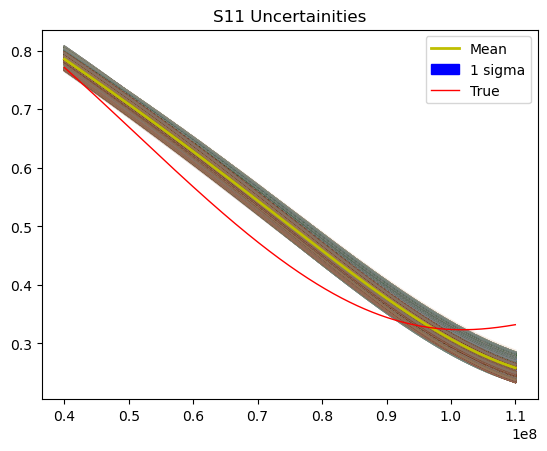

In [348]:
#plotting the correct S11 with mean S11, 1 sigma region and true value

plt.figure()
plt.plot(req_freq, S11_models[0::100].T, alpha=0.1)

S11_mean = np.mean(S11_models, axis=0)
lower_bound, upper_bound = np.percentile(S11_models,[16,84],axis=0)

plt.plot(req_freq, S11_mean, lw=2, color='y', label="Mean")
plt.fill_between(req_freq, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-2.52316013,  9.27244989, -1.40037092,  1.25994681, -7.15007581,  1.24280736,  8.85664268]

gA_True=np.polyval([p0*1e-48, p1*1e-40, p2*1e-31, p3*1e-23, p4*1e-16, p5*1e-08, p6*1e-01],req_freq)
plt.plot(req_freq,gA_True, color='r', lw=1.0, label="True")
plt.title("S11 Uncertainities")
plt.legend()
plt.show()

In [355]:
S11_models[0::100].T.shape

(2294, 5000)

In [349]:
#Recovering Uncertainities in Tmeas
TMeas=TMeas_exp_avg
TA= np.zeros((len(reduced_samples), len(req_freq)))
res= np.zeros((len(reduced_samples), len(req_freq)))
for ii in range(len(reduced_samples[::1000])):
    a, PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples[ii]
    TA_obs=Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    res[ii]=abs(TMeas-TA_obs)
    TA[ii]=TA_obs



In [361]:
print(res[0::1000]<0)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:
#plt.errorbar(req_freq, TA[0], res[0], fmt=".C9", capsize=0)
plt.plot(req_freq, TA.T,color='C1', marker="|", alpha=0.1, lw=0.5, zorder=1)
    
res_mean=np.mean(res, axis=0)
print(res_mean.shape)
TA_mean = np.mean(TA[0::1000], axis=0)
lower_bound, upper_bound = np.percentile(TA,[16,84],axis=0)

#plt.plot(req_freq, TA_mean, lw=2, color='k', label="Mean", zorder=2)
#plt.fill_between(req_freq, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")
#plt.plot(req_freq,res_mean, label="Residuals")

plt.plot(req_freq,TMeas,'.k', label='Actual', zorder=2 )
#plt.plot(req_freq,TA_exp, 'r', label="Expected")
plt.legend()
plt.title("Uncertainities Exp vs Obs TA")
plt.show()

(2294,)
